# Finding Competent Subsets for Visualization and Simulation

This notebook demonstrates the workflow for finding a competent subset for visualization.

## Import packages

In [1]:
import dpm_tools as dpm
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pyvista as pv
pv.set_jupyter_backend('static')

[13:42:59] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=639460;file://C:\Users\bcc2459\AppData\Roaming\Python\Python312\site-packages\openpnm\utils\_workspace.py\_workspace.py]8;;\:]8;id=188350;file://C:\Users\bcc2459\AppData\Roaming\Python\Python312\site-packages\openpnm\utils\_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

## Demonstration Image

We demonstrate the workflow using a beadpack and a Mt. Gambier limestone example.

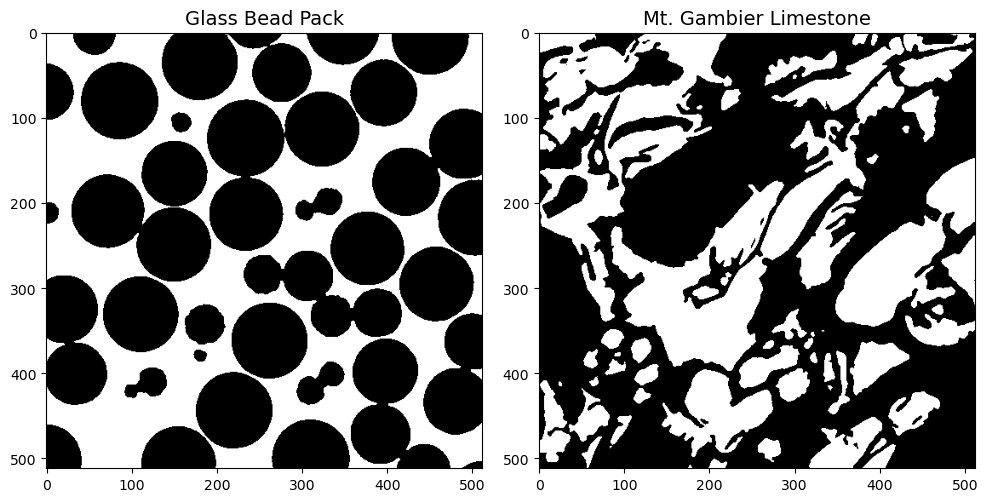

In [ ]:
image_path = Path('../../_static')
beadpack, gambier = [dpm.io.read_image(image_path / (tif_img + '.tif')) for tif_img in ['beadpack', 'mtgambier']]


fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
ax = ax.flatten()

im = ax[0].imshow(beadpack[0,:,:], cmap='gray', interpolation=None)
ax[0].set_title('Glass Bead Pack', fontsize=14)

im2 = ax[1].imshow(gambier[0,:,:], cmap='gray', interpolation=None)
ax[1].set_title('Mt. Gambier Limestone', fontsize=14)

plt.tight_layout()
plt.show()

In [10]:
def plot_sample(sample, subset=True, subset_range = (0,128)):
  
    plotter_obj = pv.Plotter(lighting='three lights')

    # Set background colors
    plotter_obj.set_background(color='w')

    # Set font colors and sizes
    pv.global_theme.font.color = 'black'
    pv.global_theme.font.size = 18
    pv.global_theme.font.label_size = 14
    
    pv.set_jupyter_backend('static')
    
    mini = subset_range[0]
    maxi = subset_range[1]

    if subset:
        sample = sample[mini:maxi,mini:maxi,mini:maxi]

    sample = np.pad(sample, ((1, 1), (1, 1), (1, 1)), mode='constant', constant_values=1)
    sample = dpm.io.Image(scalar=sample)
    
    plotter_obj = dpm.visualization.plot_isosurface(sample, plotter_obj, show_isosurface=[0.5], 
                    mesh_kwargs={"opacity":1, 
                                "color":(200 / 255, 181 / 255, 152 / 255), 
                                "diffuse": 0.75, 
                                "ambient": 0.15})
    
    
    plotter_obj.show()

### Initial Visualization

One obvious option is to arbitrarily select a subset from somewhere in the image.

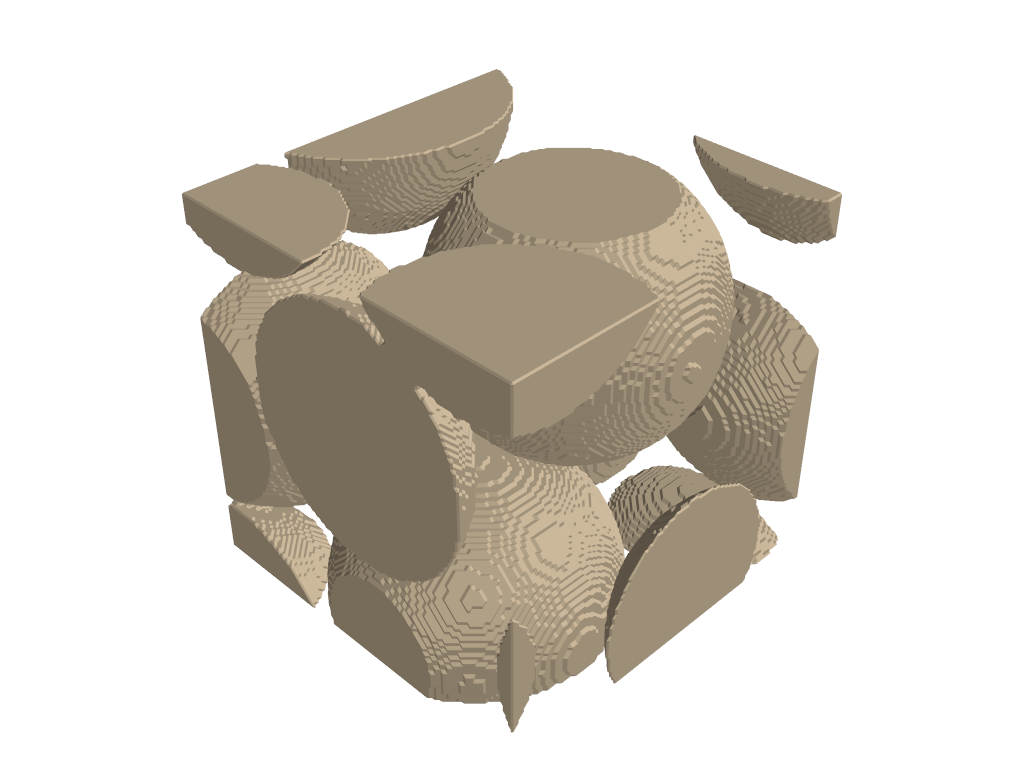

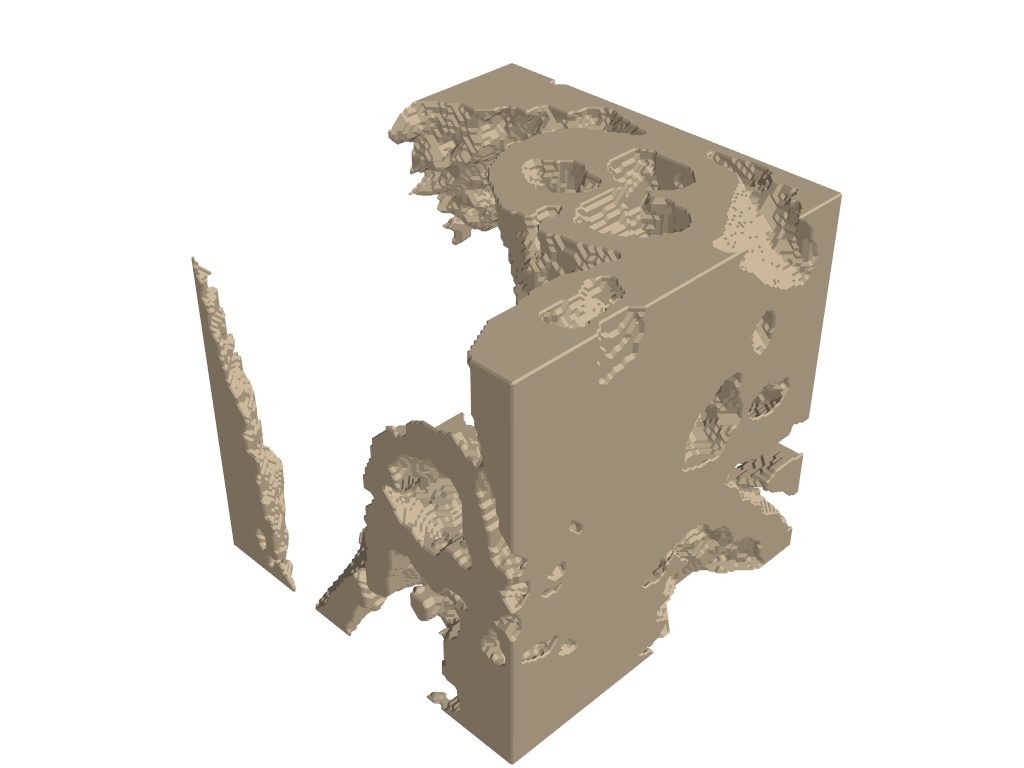

In [ ]:
subset_range = (128, 256)
plot_sample(beadpack, subset=True, subset_range=subset_range)
plot_sample(gambier, subset=True, subset_range=subset_range)


In [15]:
# Porosity of the selected subset of Gambier Limestone
gambier_128 = gambier[128:256, 128:256, 128:256]
porosity = np.sum(gambier_128 == 1)/(128**3)*100
print(round(porosity, 1), '%')

71.6 %


## Extract Competent Subset

The ``dpm_tools.visualization.extract_competent_subset()`` function identifies the best cubic subset for visualizing a segmented dataset.

**Parameters:**

 - data: A 3D numpy array, or an instance of Vector or Image class from DPM Tools.
 - cube_size: The size of the visualization cube. Default is 100 (100x100x100).
 - batch: The batch size over which to calculate the statistics. Default is 100.
 - pore_class: The class representing pores in the dataset. Default is 0.

**Description:**

The function processes the input data to find a cubic subset that best represents the porosity of the segmented dataset. It performs the following steps:

1. Porosity Calculation:

    Computes the overall porosity of the dataset.

2. Subset Selection:

    - Defines the size of the sample cube and the increment for the inner cube.
    - Calculates the maximum possible batch number and initializes a statistics array.

3. Batch Processing:

    - Iterates through possible batches to find the best subset:

        * Randomly selects a cubic subset and its inner cube.
        * Uses connected component analysis to find the largest connected components outside and inside the inner cube.
        * Calculates the porosity of the selected subset.
        * Stores the statistics if the subset's porosity is within a specified range.

4. Best Subset Identification:

    - Identifies the best subset based on the harmonic mean of the outside and inside component counts.
    - Prints the original and subset porosity, and the range of the competent subset.


**Returns:**

``best_subset_range``: A tuple representing the range of the best subset.

``stats_array``: An array containing the statistics of the processed batches.

In [16]:
beadpack_subset, _ = dpm.visualization.extract_competent_subset(beadpack, cube_size=128, batch=100, pore_class = 1)

Original Porosity: 37.88 %
Subset Porosity: 35.53 %
Competent Subset: [93:221,93:221, 93:221]


In [17]:
gambier_subset, _ = dpm.visualization.extract_competent_subset(gambier, cube_size=128, batch=100, pore_class = 1)

Original Porosity: 43.59 %
Subset Porosity: 41.18 %
Competent Subset: [32:160,32:160, 32:160]


## Final Visualizations

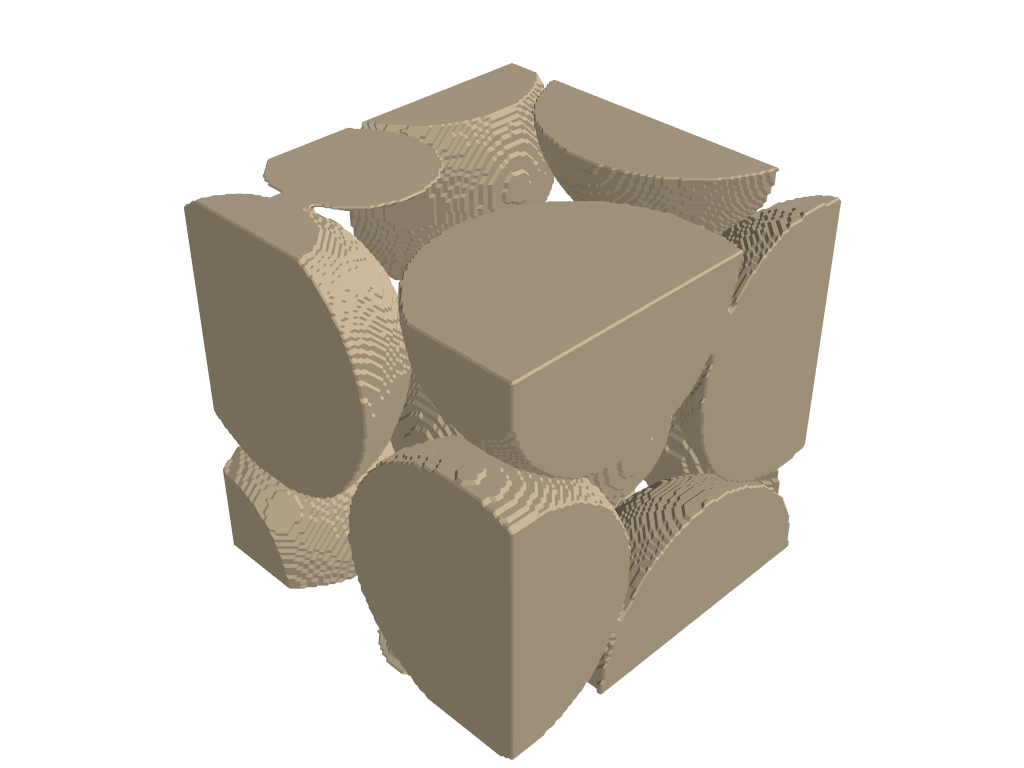

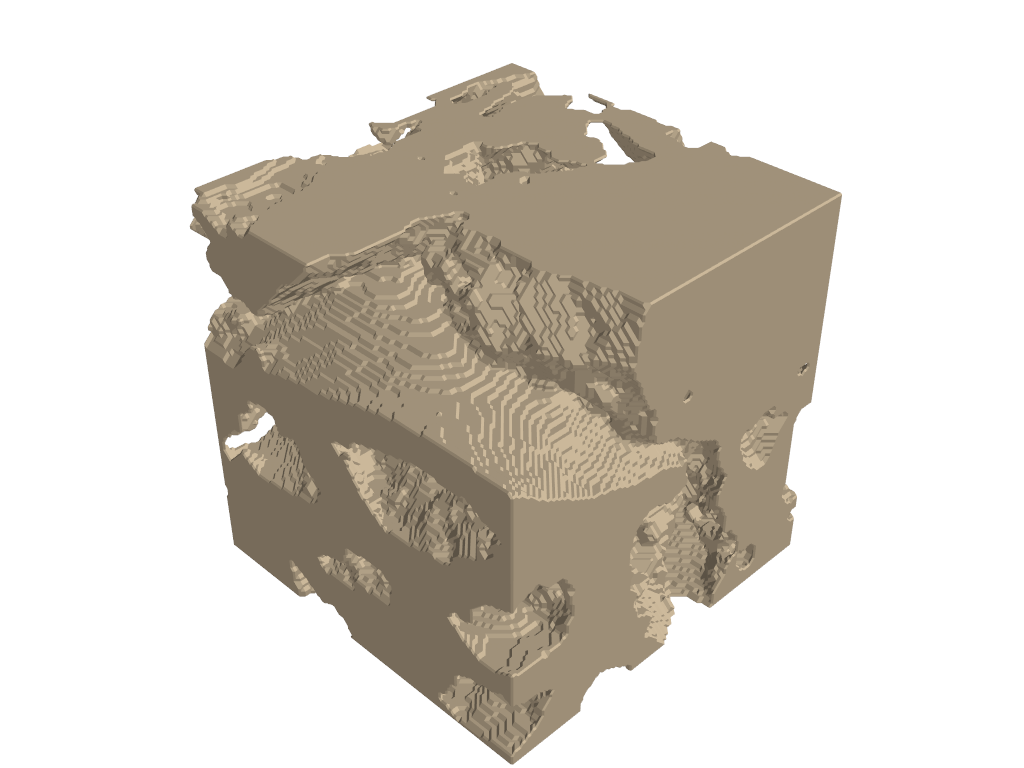

In [18]:
plot_sample(beadpack, subset=True, subset_range=beadpack_subset)
plot_sample(gambier, subset=True, subset_range=gambier_subset)